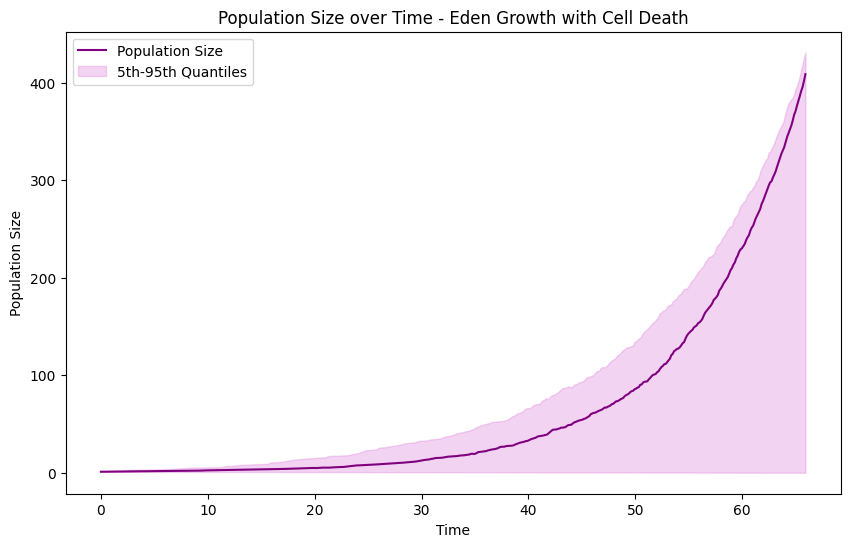

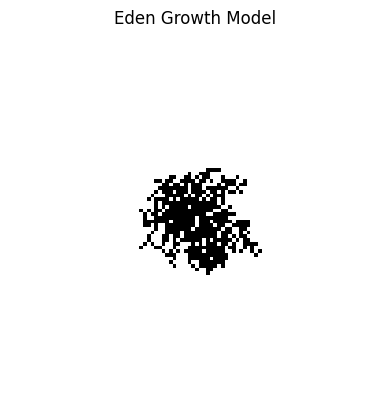

Extinction rate: 10.00%


In [14]:
import numpy as np
import matplotlib.pyplot as plt

def initialize_grid(size):
    grid = np.zeros((size, size), dtype=int)
    center = size // 2
    grid[center, center] = 1
    border = set()
    dividing_cells = set([(center, center)])
    for nx, ny in get_moore_neighborhood(center, center, size):
        border.add((nx, ny))
    return grid, border, dividing_cells

def get_moore_neighborhood(x, y, size):
    neighbors = [(x+i, y+j) for i in range(-1, 2) for j in range(-1, 2) if (i != 0 or j != 0)]
    valid_neighbors = [(nx, ny) for nx, ny in neighbors if 0 <= nx < size and 0 <= ny < size]
    return valid_neighbors

def grow_cluster(grid, border, dividing_cells, iterations, base_growth_rate, base_death_prob):
    size = len(grid)
    population_size = [1]
    time_points = [0]

    for _ in range(iterations):
        if not border:
            break
        
        N = np.sum(grid)
        num_dividing_cells = len(dividing_cells)
        
        summed_death = base_death_prob * N
        summed_birth = base_growth_rate * num_dividing_cells
        
        total_rate = summed_death + summed_birth
        if total_rate == 0:
            break
        
        next_event_time = np.random.exponential(1 / total_rate)
        time_points.append(time_points[-1] + next_event_time)
        
        if np.random.rand() < summed_birth / total_rate:
            new_site = list(border)[np.random.randint(len(border))]
            grid[new_site] = 1
            population_size.append(np.sum(grid))
            border.remove(new_site)
            dividing_cells.add(new_site)
            for nx, ny in get_moore_neighborhood(*new_site, size):
                if grid[nx, ny] == 0:
                    border.add((nx, ny))
                elif grid[nx, ny] == 1:
                    dividing_cells.add((nx, ny))
        else:
            living_cells = list(dividing_cells)
            if living_cells:
                death_site = living_cells[np.random.randint(len(living_cells))]
                grid[death_site] = 0
                population_size.append(np.sum(grid))
                dividing_cells.remove(death_site)
                border.discard(death_site)
                for nx, ny in get_moore_neighborhood(*death_site, size):
                    if grid[nx, ny] == 1:
                        dividing_cells.add((nx, ny))
                    elif grid[nx, ny] == 0:
                        border.add((nx, ny))
    
    return grid, population_size, time_points

def plot_grid(grid):
    plt.imshow(grid, cmap='Greys', interpolation='nearest')
    plt.title('Eden Growth Model')
    plt.axis('off')
    plt.show()

# Parameters
grid_size = 100
iterations = 500
base_growth_rate = 0.1
base_death_prob = 0.01
num_simulations = 100

# Run multiple simulations
all_population_sizes = []
all_time_points = []

for _ in range(num_simulations):
    grid, population_size, time_points = grow_cluster(*initialize_grid(grid_size), iterations, base_growth_rate, base_death_prob)
    all_population_sizes.append(np.interp(np.linspace(0, max(time_points), iterations), time_points, population_size))
    all_time_points.append(np.linspace(0, max(time_points), iterations))

all_population_sizes = np.array(all_population_sizes)
time_points = np.mean(all_time_points, axis=0)

# Calculate quantiles
quantiles_1 = np.percentile(all_population_sizes, 5, axis=0)
quantiles_2 = np.percentile(all_population_sizes, 95, axis=0)
median_population_size = np.median(all_population_sizes, axis=0)

# Plot population size over time
plt.figure(figsize=(10, 6))
plt.plot(time_points, median_population_size, label='Population Size', color='purple')
plt.fill_between(time_points, quantiles_1, quantiles_2, color='orchid', alpha=0.3, label='5th-95th Quantiles')
plt.xlabel('Time')
plt.ylabel('Population Size')
plt.title('Population Size over Time - Eden Growth with Cell Death')
plt.legend()
plt.show()

# Plot final grid 
plot_grid(grid)

# Extinction analysis
extinction_count = np.sum(all_population_sizes[:, -1] == 0)
total_simulations = num_simulations
extinction_rate = extinction_count / total_simulations * 100

print(f"Extinction rate: {extinction_rate:.2f}%")
